In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22280 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.0-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.0-0ubuntu1~ubuntu18.04.1) ...


In [0]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

In [3]:
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [4]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

adc.json  drive  sample_data


In [0]:
!ls drive

In [7]:
!ls drive/NeuralNetsProject2-DATA

models	test  train  validation


In [6]:
!ls drive/NeuralNetsProject2/figures

ls: cannot access 'drive/NeuralNetsProject2/figures': No such file or directory


In [0]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

In [0]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 100
batch_size = 128
num_dense = 300

In [0]:
seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [0]:
def load_data(file):
    with open(file, 'rb') as fo:
        try:
            samples = pickle.load(fo)
        except UnicodeDecodeError:  #python 3.x
            fo.seek(0)
            samples = pickle.load(fo, encoding='latin1')

    data, labels = samples['data'], samples['labels']

    data = np.array(data, dtype=np.float32)
    labels = np.array(labels, dtype=np.int32)

    
    labels_ = np.zeros([labels.shape[0], NUM_CLASSES])
    labels_[np.arange(labels.shape[0]), labels-1] = 1

    return data, labels_

In [0]:
# Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])
keep_prob = tf.placeholder(tf.float32)

In [0]:
def cnn(images, num_conv_1=50, num_conv_2=60):

    images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    
    #Conv 1
    W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, num_conv_1], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
    b1 = tf.Variable(tf.zeros([num_conv_1]), name='biases_1')

    conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
    pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')
    pool_1_drop = tf.nn.dropout(pool_1, keep_prob)

    
    #Conv 2
    W2 = tf.Variable(tf.truncated_normal([5, 5, num_conv_1, num_conv_2], stddev=1.0/np.sqrt(NUM_CHANNELS*5*5)), name='weights_2')
    b2 = tf.Variable(tf.zeros([num_conv_2]), name='biases_2')

    conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1_drop, W2, [1, 1, 1, 1], padding='VALID') + b2)
    pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')
    pool_2_drop = tf.nn.dropout(pool_2, keep_prob)
    
    #flattened layer
    dim = pool_2.get_shape()[1].value * pool_2.get_shape()[2].value * pool_2.get_shape()[3].value 
    pool_2_flat = tf.reshape(pool_2, [-1, dim])
    
    #fully connected layer
#     W3 = tf.Variable(tf.truncated_normal([dim, num_dense], stddev=1.0/np.sqrt(num_dense)), name='weights_3')
#     b3 = tf.Variable(tf.zeros([num_dense]), name='biases_3')
    fc = tf.layers.dense(pool_2_flat, num_dense, activation=tf.nn.relu)
    fc_dropout = tf.nn.dropout(fc, keep_prob)
    
    #softmax
    W4 = tf.Variable(tf.truncated_normal([num_dense, NUM_CLASSES], stddev=1.0/np.sqrt(dim)), name='weights_4')
    b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_4')
    logits = tf.matmul(fc_dropout, W4) + b4

    return conv_1, pool_1, conv_2, pool_2, pool_2_flat, logits

In [17]:
trainX, trainY = load_data('drive/NeuralNetsProject2-DATA/train/data_batch_1')
print(trainX.shape, trainY.shape)

(10000, 3072) (10000, 10)


In [27]:
testX, testY = load_data('drive/NeuralNetsProject2-DATA/test/test_batch_trim')
print(testX.shape, testY.shape)

(2000, 3072) (2000, 10)


In [0]:

trainX = (trainX - np.min(trainX, axis = 0))/(np.max(trainX, axis = 0)-np.min(trainX, axis = 0))
testX = (testX - np.min(testX, axis = 0))/(np.max(testX, axis = 0)-np.min(testX, axis = 0))

conv_1, pool_1, conv_2, pool_2, pool_2_flat, logits = cnn(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)

correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

N = len(trainX)
idx = np.arange(N)



**Part A Question 1**

epoch 99 entropy: 1.640156626701355, test accuracy: 0.3970000147819519

test pattern 1895


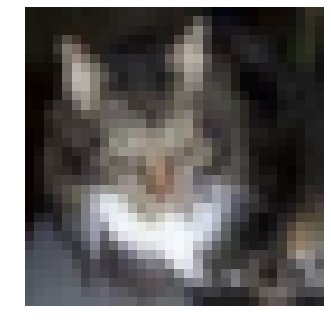

feature map at conv1


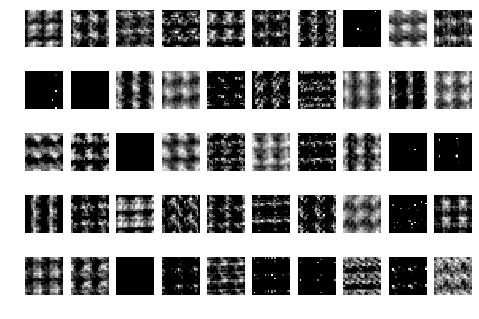

feature map at pool1


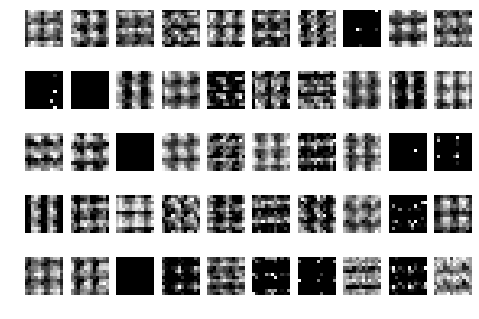

feature map at conv2


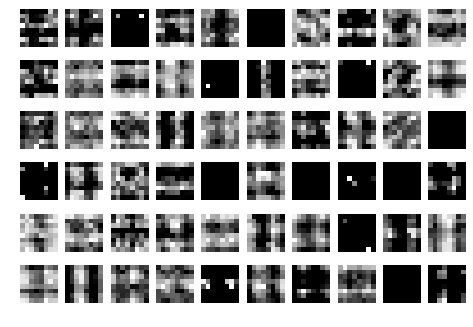

feature map at pool2


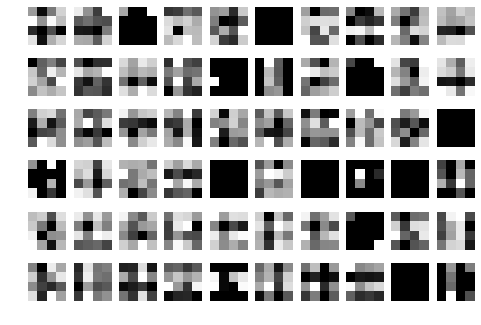

test pattern 783


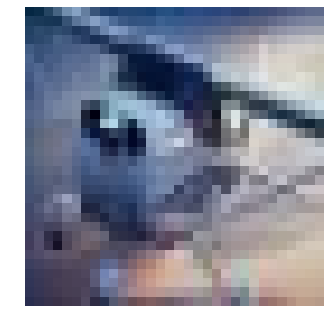

feature map at conv1


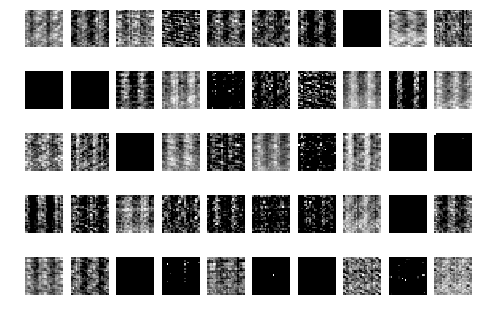

feature map at pool1


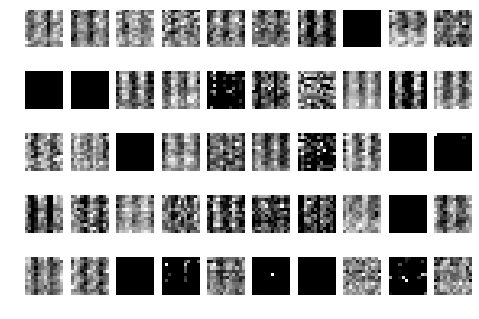

feature map at conv2


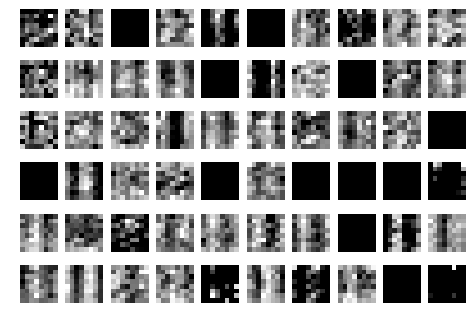

feature map at pool2


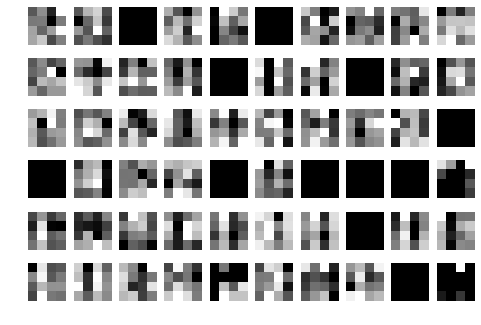

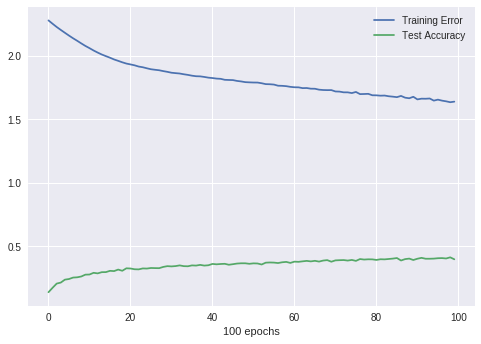

In [20]:
train_cost = []
test_acc = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY = trainX[idx], trainY[idx]
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_step.run(feed_dict={x: trainX[start: end], y_: trainY[start:end], keep_prob: 1})
        
        loss_ = loss.eval(feed_dict={x: trainX, y_: trainY, keep_prob:1})
        train_cost.append(loss_)
        acc_ = accuracy.eval(feed_dict={x: testX, y_: testY, keep_prob:1})
        test_acc.append(acc_)
        print('\repoch {} entropy: {}, test accuracy: {}'.format(e, loss_, acc_), end="")
        
        
    # for printing and viusals
    print("\n")
    ind = np.random.randint(low=0, high=2000, size=2)
    for index, i in enumerate(ind):
        X = testX[i,:]

        conv1_, pool1_, conv2_, pool2_ = sess.run([conv_1, pool_1, conv_2, pool_2],
                                                      {x: X.reshape(1, NUM_CHANNELS*IMG_SIZE*IMG_SIZE), keep_prob:1})

        print("test pattern", i)
        plt.figure()
        X_show = X.reshape(NUM_CHANNELS, IMG_SIZE, IMG_SIZE).transpose(1, 2, 0)
        plt.axis('off')
        plt.imshow(X_show)
        plt.savefig('drive/NeuralNetsProject2/figures/parta/1b_testpattern' + str(index) + '.png')
        plt.show()

        print("feature map at conv1")
        plt.figure()
        plt.gray()
        h_conv1_ = np.array(conv1_)
        for i in range(50):
            plt.subplot(5, 10, i+1); plt.axis('off'); plt.imshow(conv1_[0,:,:,i])
        plt.savefig('drive/NeuralNetsProject2/figures/parta/1b_conv1' + str(index) + '.png')
        plt.show()

        print("feature map at pool1")
        plt.figure()
        plt.gray()
        h_pool1_ = np.array(pool1_)
        for i in range(50):
            plt.subplot(5, 10, i+1); plt.axis('off'); plt.imshow(pool1_[0,:,:,i])
        plt.savefig('drive/NeuralNetsProject2/figures/parta/1b_pool1' + str(index) + '.png')
        plt.show()

        print("feature map at conv2")
        plt.figure()
        plt.gray()
        h_conv2_ = np.array(conv2_)
        for i in range(60):
            plt.subplot(6, 10, i+1); plt.axis('off'); plt.imshow(conv2_[0,:,:,i])
        plt.savefig('drive/NeuralNetsProject2/figures/parta/1b_conv2' + str(index) + '.png')
        plt.show()

        print("feature map at pool2")
        plt.figure()
        plt.gray()
        h_pool2_ = np.array(pool2_)
        for i in range(60):
            plt.subplot(6, 10, i+1); plt.axis('off'); plt.imshow(pool2_[0,:,:,i])
        plt.savefig('drive/NeuralNetsProject2/figures/parta/1b_pool2' + str(index) + '.png')
        plt.show()

    plt.figure()
    plt.plot(range(epochs), train_cost)
    plt.plot(range(epochs), test_acc)
    plt.xlabel(str(epochs)+' epochs')
    plt.legend(["Training Error", "Test Accuracy"])
    plt.savefig('drive/NeuralNetsProject2/figures/parta/q1.png')

**PART A QUESTION 2**

In [0]:
grid_conv1 = range(20, 120, 10)
grid_conv2 = range(20, 120, 10)
from itertools import product
grid = product(grid_conv1, grid_conv2)

In [20]:
import tqdm
all_test_acc = []
best = 0
optimal_conv_1 = 0
optimal_conv_2 = 0
for num_conv_1, num_conv_2 in tqdm.tqdm(grid):
    x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])


    _, _, _, _, _, logits = cnn(x, num_conv_1, num_conv_2)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

    N = len(trainX)
    idx = np.arange(N)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for e in range(epochs):
            np.random.shuffle(idx)
            trainX, trainY = trainX[idx], trainY[idx]
            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                train_step.run(feed_dict={x: trainX[start: end], y_: trainY[start:end], keep_prob:1})

        _test_acc = accuracy.eval(feed_dict={x: testX, y_: testY, keep_prob:1})
        if _test_acc > best:
            best = _test_acc
            optimal_conv_1 = num_conv_1
            optimal_conv_2 = num_conv_2
        all_test_acc.append(test_acc)
        print('Test Accuracy: {} for {} filters in conv1 and {} filters in conv2'.format(_test_acc, num_conv_1, num_conv_2))

print("optimal number of filters for first conv layer is", optimal_conv_1)
print("optimal number of filters for second conv layer is", optimal_conv_2)
print("test accuracy of:", best)

1it [00:52, 52.44s/it]

Test Accuracy: 0.32899999618530273 for 20 filters in conv1 and 20 filters in conv2


2it [01:45, 52.73s/it]

Test Accuracy: 0.3400000035762787 for 20 filters in conv1 and 30 filters in conv2


3it [02:42, 53.87s/it]

Test Accuracy: 0.3630000054836273 for 20 filters in conv1 and 40 filters in conv2


4it [03:40, 55.17s/it]

Test Accuracy: 0.36550000309944153 for 20 filters in conv1 and 50 filters in conv2


5it [04:41, 56.81s/it]

Test Accuracy: 0.3714999854564667 for 20 filters in conv1 and 60 filters in conv2


6it [05:44, 58.81s/it]

Test Accuracy: 0.3774999976158142 for 20 filters in conv1 and 70 filters in conv2


7it [06:48, 60.40s/it]

Test Accuracy: 0.37549999356269836 for 20 filters in conv1 and 80 filters in conv2


8it [07:55, 62.22s/it]

Test Accuracy: 0.36899998784065247 for 20 filters in conv1 and 90 filters in conv2


9it [09:04, 64.37s/it]

Test Accuracy: 0.3540000021457672 for 20 filters in conv1 and 100 filters in conv2


10it [10:14, 66.06s/it]

Test Accuracy: 0.3720000088214874 for 20 filters in conv1 and 110 filters in conv2


11it [11:13, 63.96s/it]

Test Accuracy: 0.36800000071525574 for 30 filters in conv1 and 20 filters in conv2


12it [12:14, 62.99s/it]

Test Accuracy: 0.3610000014305115 for 30 filters in conv1 and 30 filters in conv2


13it [13:17, 63.07s/it]

Test Accuracy: 0.3605000078678131 for 30 filters in conv1 and 40 filters in conv2


14it [14:23, 63.91s/it]

Test Accuracy: 0.38100001215934753 for 30 filters in conv1 and 50 filters in conv2


15it [15:31, 64.97s/it]

Test Accuracy: 0.39500001072883606 for 30 filters in conv1 and 60 filters in conv2


16it [16:40, 66.42s/it]

Test Accuracy: 0.3840000033378601 for 30 filters in conv1 and 70 filters in conv2


17it [17:51, 67.83s/it]

Test Accuracy: 0.3619999885559082 for 30 filters in conv1 and 80 filters in conv2


18it [19:05, 69.63s/it]

Test Accuracy: 0.38850000500679016 for 30 filters in conv1 and 90 filters in conv2


19it [20:22, 71.62s/it]

Test Accuracy: 0.34299999475479126 for 30 filters in conv1 and 100 filters in conv2


20it [21:39, 73.47s/it]

Test Accuracy: 0.3700000047683716 for 30 filters in conv1 and 110 filters in conv2


21it [22:49, 72.27s/it]

Test Accuracy: 0.375 for 40 filters in conv1 and 20 filters in conv2


22it [24:00, 71.90s/it]

Test Accuracy: 0.33250001072883606 for 40 filters in conv1 and 30 filters in conv2


23it [25:14, 72.57s/it]

Test Accuracy: 0.37599998712539673 for 40 filters in conv1 and 40 filters in conv2


24it [26:32, 74.11s/it]

Test Accuracy: 0.3540000021457672 for 40 filters in conv1 and 50 filters in conv2


25it [27:51, 75.60s/it]

Test Accuracy: 0.33250001072883606 for 40 filters in conv1 and 60 filters in conv2


26it [29:13, 77.64s/it]

Test Accuracy: 0.3384999930858612 for 40 filters in conv1 and 70 filters in conv2


27it [30:36, 79.30s/it]

Test Accuracy: 0.3734999895095825 for 40 filters in conv1 and 80 filters in conv2


28it [32:03, 81.53s/it]

Test Accuracy: 0.38100001215934753 for 40 filters in conv1 and 90 filters in conv2


29it [33:33, 84.01s/it]

Test Accuracy: 0.39250001311302185 for 40 filters in conv1 and 100 filters in conv2


30it [35:04, 86.18s/it]

Test Accuracy: 0.36899998784065247 for 40 filters in conv1 and 110 filters in conv2


31it [36:22, 83.60s/it]

Test Accuracy: 0.36899998784065247 for 50 filters in conv1 and 20 filters in conv2


32it [37:41, 82.30s/it]

Test Accuracy: 0.36800000071525574 for 50 filters in conv1 and 30 filters in conv2


33it [39:04, 82.50s/it]

Test Accuracy: 0.3564999997615814 for 50 filters in conv1 and 40 filters in conv2


34it [40:30, 83.68s/it]

Test Accuracy: 0.38449999690055847 for 50 filters in conv1 and 50 filters in conv2


35it [41:59, 85.10s/it]

Test Accuracy: 0.35100001096725464 for 50 filters in conv1 and 60 filters in conv2


36it [43:31, 87.23s/it]

Test Accuracy: 0.34700000286102295 for 50 filters in conv1 and 70 filters in conv2


37it [45:04, 89.06s/it]

Test Accuracy: 0.39250001311302185 for 50 filters in conv1 and 80 filters in conv2


38it [46:42, 91.70s/it]

Test Accuracy: 0.3529999852180481 for 50 filters in conv1 and 90 filters in conv2


39it [48:23, 94.53s/it]

Test Accuracy: 0.3644999861717224 for 50 filters in conv1 and 100 filters in conv2


40it [50:06, 97.02s/it]

Test Accuracy: 0.36800000071525574 for 50 filters in conv1 and 110 filters in conv2


41it [51:30, 93.17s/it]

Test Accuracy: 0.3474999964237213 for 60 filters in conv1 and 20 filters in conv2


42it [52:56, 90.92s/it]

Test Accuracy: 0.38100001215934753 for 60 filters in conv1 and 30 filters in conv2


43it [54:25, 90.49s/it]

Test Accuracy: 0.3779999911785126 for 60 filters in conv1 and 40 filters in conv2


44it [55:59, 91.27s/it]

Test Accuracy: 0.3734999895095825 for 60 filters in conv1 and 50 filters in conv2


45it [57:34, 92.47s/it]

Test Accuracy: 0.3634999990463257 for 60 filters in conv1 and 60 filters in conv2


46it [59:13, 94.39s/it]

Test Accuracy: 0.35600000619888306 for 60 filters in conv1 and 70 filters in conv2


47it [1:00:53, 96.21s/it]

Test Accuracy: 0.38449999690055847 for 60 filters in conv1 and 80 filters in conv2


48it [1:02:37, 98.59s/it]

Test Accuracy: 0.4000000059604645 for 60 filters in conv1 and 90 filters in conv2


49it [1:04:24, 101.12s/it]

Test Accuracy: 0.38749998807907104 for 60 filters in conv1 and 100 filters in conv2


50it [1:06:13, 103.44s/it]

Test Accuracy: 0.39399999380111694 for 60 filters in conv1 and 110 filters in conv2


51it [1:07:49, 101.03s/it]

Test Accuracy: 0.33899998664855957 for 70 filters in conv1 and 20 filters in conv2


52it [1:09:26, 99.82s/it] 

Test Accuracy: 0.3555000126361847 for 70 filters in conv1 and 30 filters in conv2


53it [1:11:07, 100.45s/it]

Test Accuracy: 0.37049999833106995 for 70 filters in conv1 and 40 filters in conv2


54it [1:12:54, 102.18s/it]

Test Accuracy: 0.3869999945163727 for 70 filters in conv1 and 50 filters in conv2


55it [1:14:42, 103.97s/it]

Test Accuracy: 0.40450000762939453 for 70 filters in conv1 and 60 filters in conv2


56it [1:16:34, 106.45s/it]

Test Accuracy: 0.3720000088214874 for 70 filters in conv1 and 70 filters in conv2


57it [1:18:28, 108.62s/it]

Test Accuracy: 0.3880000114440918 for 70 filters in conv1 and 80 filters in conv2


58it [1:20:26, 111.48s/it]

Test Accuracy: 0.3720000088214874 for 70 filters in conv1 and 90 filters in conv2


59it [1:22:29, 114.85s/it]

Test Accuracy: 0.4104999899864197 for 70 filters in conv1 and 100 filters in conv2


60it [1:24:33, 117.60s/it]

Test Accuracy: 0.414000004529953 for 70 filters in conv1 and 110 filters in conv2


61it [1:26:14, 112.83s/it]

Test Accuracy: 0.39399999380111694 for 80 filters in conv1 and 20 filters in conv2


62it [1:27:57, 109.93s/it]

Test Accuracy: 0.382999986410141 for 80 filters in conv1 and 30 filters in conv2


63it [1:29:45, 109.17s/it]

Test Accuracy: 0.34299999475479126 for 80 filters in conv1 and 40 filters in conv2


64it [1:31:37, 109.96s/it]

Test Accuracy: 0.3930000066757202 for 80 filters in conv1 and 50 filters in conv2


65it [1:33:30, 111.01s/it]

Test Accuracy: 0.40400001406669617 for 80 filters in conv1 and 60 filters in conv2


66it [1:35:28, 113.08s/it]

Test Accuracy: 0.3684999942779541 for 80 filters in conv1 and 70 filters in conv2


67it [1:37:28, 115.01s/it]

Test Accuracy: 0.35600000619888306 for 80 filters in conv1 and 80 filters in conv2


68it [1:39:32, 117.75s/it]

Test Accuracy: 0.40950000286102295 for 80 filters in conv1 and 90 filters in conv2


69it [1:41:40, 120.99s/it]

Test Accuracy: 0.39100000262260437 for 80 filters in conv1 and 100 filters in conv2


70it [1:43:50, 123.69s/it]

Test Accuracy: 0.4104999899864197 for 80 filters in conv1 and 110 filters in conv2


71it [1:45:41, 119.74s/it]

Test Accuracy: 0.33000001311302185 for 90 filters in conv1 and 20 filters in conv2


72it [1:47:33, 117.47s/it]

Test Accuracy: 0.36149999499320984 for 90 filters in conv1 and 30 filters in conv2


73it [1:49:30, 117.45s/it]

Test Accuracy: 0.37299999594688416 for 90 filters in conv1 and 40 filters in conv2


74it [1:51:33, 119.12s/it]

Test Accuracy: 0.39750000834465027 for 90 filters in conv1 and 50 filters in conv2


75it [1:53:38, 120.87s/it]

Test Accuracy: 0.39750000834465027 for 90 filters in conv1 and 60 filters in conv2


76it [1:55:48, 123.50s/it]

Test Accuracy: 0.3804999887943268 for 90 filters in conv1 and 70 filters in conv2


77it [1:57:59, 125.72s/it]

Test Accuracy: 0.3720000088214874 for 90 filters in conv1 and 80 filters in conv2


78it [2:00:16, 129.01s/it]

Test Accuracy: 0.38749998807907104 for 90 filters in conv1 and 90 filters in conv2


79it [2:02:37, 132.62s/it]

Test Accuracy: 0.38749998807907104 for 90 filters in conv1 and 100 filters in conv2


80it [2:05:01, 136.24s/it]

Test Accuracy: 0.39250001311302185 for 90 filters in conv1 and 110 filters in conv2


81it [2:07:02, 131.72s/it]

Test Accuracy: 0.3499999940395355 for 100 filters in conv1 and 20 filters in conv2


82it [2:09:05, 128.88s/it]

Test Accuracy: 0.3675000071525574 for 100 filters in conv1 and 30 filters in conv2


83it [2:11:12, 128.45s/it]

Test Accuracy: 0.38100001215934753 for 100 filters in conv1 and 40 filters in conv2


84it [2:13:26, 129.93s/it]

Test Accuracy: 0.35749998688697815 for 100 filters in conv1 and 50 filters in conv2


85it [2:15:41, 131.71s/it]

Test Accuracy: 0.39399999380111694 for 100 filters in conv1 and 60 filters in conv2


86it [2:18:02, 134.40s/it]

Test Accuracy: 0.37549999356269836 for 100 filters in conv1 and 70 filters in conv2


87it [2:20:25, 136.84s/it]

Test Accuracy: 0.39100000262260437 for 100 filters in conv1 and 80 filters in conv2


88it [2:22:53, 140.26s/it]

Test Accuracy: 0.4025000035762787 for 100 filters in conv1 and 90 filters in conv2


89it [2:25:27, 144.49s/it]

Test Accuracy: 0.38999998569488525 for 100 filters in conv1 and 100 filters in conv2


90it [2:28:05, 148.34s/it]

Test Accuracy: 0.38449999690055847 for 100 filters in conv1 and 110 filters in conv2


91it [2:30:13, 142.31s/it]

Test Accuracy: 0.34299999475479126 for 110 filters in conv1 and 20 filters in conv2


92it [2:32:22, 138.51s/it]

Test Accuracy: 0.36899998784065247 for 110 filters in conv1 and 30 filters in conv2


93it [2:34:38, 137.50s/it]

Test Accuracy: 0.3630000054836273 for 110 filters in conv1 and 40 filters in conv2


94it [2:36:58, 138.44s/it]

Test Accuracy: 0.39750000834465027 for 110 filters in conv1 and 50 filters in conv2


95it [2:39:21, 139.65s/it]

Test Accuracy: 0.39800000190734863 for 110 filters in conv1 and 60 filters in conv2
Test Accuracy: 0.37049999833106995 for 110 filters in conv1 and 70 filters in conv2


97it [2:44:18, 144.43s/it]

Test Accuracy: 0.39250001311302185 for 110 filters in conv1 and 80 filters in conv2


98it [2:46:57, 148.77s/it]

Test Accuracy: 0.36500000953674316 for 110 filters in conv1 and 90 filters in conv2


99it [2:49:41, 153.13s/it]

Test Accuracy: 0.33899998664855957 for 110 filters in conv1 and 100 filters in conv2


100it [2:52:29, 157.56s/it]

Test Accuracy: 0.3684999942779541 for 110 filters in conv1 and 110 filters in conv2
optimal number of filters for first conv layer is 70
optimal number of filters for second conv layer is 110
test accuracy of: 0.414


**Part A Question 3 **

In [0]:
optimal_conv_1 = 70
optimal_conv_2 = 110

epoch 99 entropy: 1.5757598876953125, test accuracy: 0.4415000081062317Momentum done
epoch 99 entropy: 0.005475211888551712, test accuracy: 0.4869999885559082RMSProp done
epoch 99 entropy: 6.285304698394611e-05, test accuracy: 0.4934999942779541Adam done
epoch 99 entropy: 1.764500379562378, test accuracy: 0.3815000057220459GradientDescent done


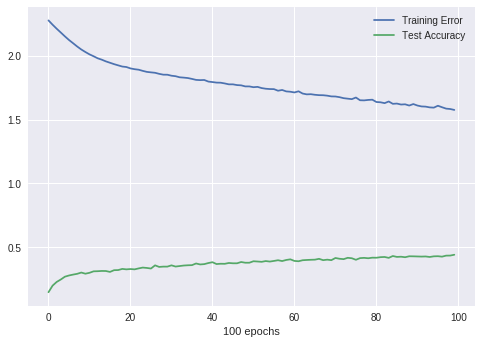

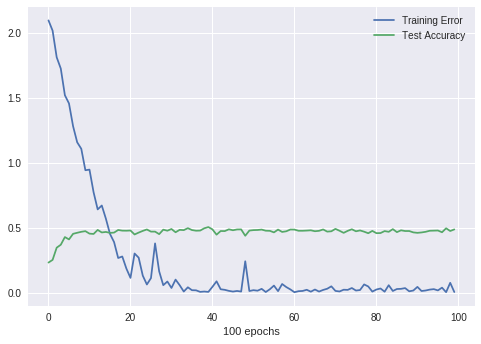

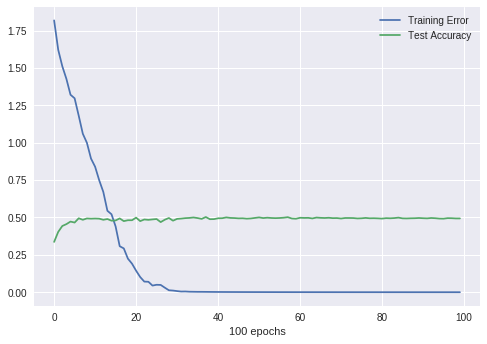

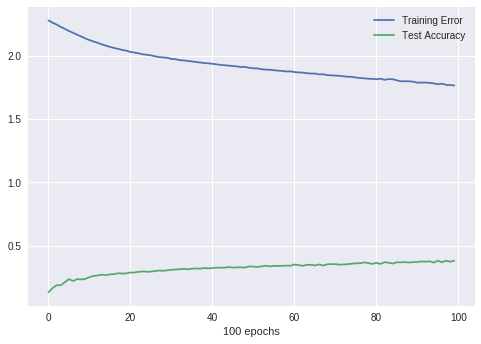

In [33]:
# Create the model

learning_rate = 0.001
momentum = 0.1
momentum_opt = tf.train.MomentumOptimizer(learning_rate, momentum)

rmsprop_opt = tf.train.RMSPropOptimizer(learning_rate)

adam_opt = tf.train.AdamOptimizer(learning_rate)

gradientdesc_opt = tf.train.GradientDescentOptimizer(learning_rate)

models = [momentum_opt, rmsprop_opt, adam_opt, gradientdesc_opt]

for model in models:
    dropout = 0.7 if model.get_name() == 'GradientDescent' else 1
        
    x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
    y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])


    _, _, _, _, _, logits = cnn(x, optimal_conv_1, optimal_conv_2)

    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
    loss = tf.reduce_mean(cross_entropy)

    correct_prediction = tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1)), tf.float32)
    accuracy = tf.reduce_mean(correct_prediction)

    train_step = model.minimize(loss)

    N = len(trainX)
    idx = np.arange(N)

    train_cost = []
    test_acc = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        for e in range(epochs):
            np.random.shuffle(idx)
            trainX, trainY = trainX[idx], trainY[idx]
            for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
                train_step.run(feed_dict={x: trainX[start: end], y_: trainY[start:end], keep_prob: dropout})

            loss_ = loss.eval(feed_dict={x: trainX, y_: trainY, keep_prob: 1})
            train_cost.append(loss_)
            acc_ = accuracy.eval(feed_dict={x: testX, y_: testY, keep_prob: 1})
            test_acc.append(acc_)
            print('\repoch {} entropy: {}, test accuracy: {}'.format(e, loss_, acc_), end="")

        plt.figure()
        plt.plot(range(epochs), train_cost)
        plt.plot(range(epochs), test_acc)
        plt.xlabel(str(epochs)+' epochs')
        plt.legend(["Training Error", "Test Accuracy"])
        plt.savefig('drive/NeuralNetsProject2/figures/parta/q3_' + model.get_name() + '.png')

        print("{} done".format(model.get_name()))